In [7]:
import sys
# sys.setdefaultencoding() does not exist, here!
reload(sys)  # Reload does the trick!
sys.setdefaultencoding('utf-8')

In [8]:
%matplotlib inline
from IPython.core. pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [9]:
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [10]:
from matplotlib import font_manager

# 폰트 경로가 인식되지 않는 문제가 있다
font_dirs = ['/Library/Fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

## 1.4 컴퓨터를 사용하여 베이지안 추론하기

### 1.4.1 예제 : 문자 메시지 데이터에서 행동 추론하기

어느 사용자가 매일 주고 받은 문자 메시지를 통하여 사용자의 메시지 습관이 시간별로 서서히 변하는지 갑자기 급변하는지 알고 싶다.

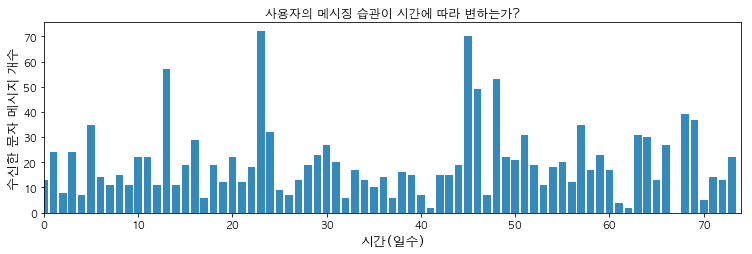

In [11]:
figsize(12.5, 3.5)

count_data = np.loadtxt(r"data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel(u"시간(일수)",fontsize=13)
plt.ylabel(u"수신한 문자 메시지 개수",fontsize=13)
plt.title(u"사용자의 메시징 습관이 시간에 따라 변하는가?")
plt.xlim(0, n_count_data);

푸아송 분포를 통해서 그림에서 주어진 시간동안 행동의 변화를 모델링  
특정일자 $i$의 메시지 개수는 $C_i$로 표시

<center>$C_{i} \sim Poi(\lambda)$</center>

$\tau$ : 곽측기간 중 어느날  
모수 $\lambda$가 갑자기 더 높은 값으로 확 뛰어 오른다고 가정하면  
특정 날짜를 기준으로 모수 $\lambda$를 2개 가진다.  

변환점 : 급잓러운 변화가 일어나는 지점  

<center>$\lambda =
\begin{cases}
\lambda_1, & if t < \tau \\
\lambda_2, & if t \ge \tau
\end{cases}$</center>

$\lambda$를 추론할려고 함, 베이지안 추론을 사용하기 위해 $\lambda$의 여러 가능한 값에 사전확률을할당 해야함  

이를 지수분포를 통해서 모델링, 지수분포의 모수 $\alpha$

$\alpha$는 초모수 또는 부모변수  


<center>$\lambda_{1} \sim Exp(\alpha)$</center>
<center>$\lambda_{2} \sim Exp(\alpha)$</center>

$\alpha$를 개수 데이터 평균의 역수가 되도록 설정

<center>${1\over N} \sum_{i = 0}^N C_i \approx E[\lambda|\alpha] = {1\over\alpha}$</center>

$\tau$가 발생할 경우 데이터 노이즈 때문에 사전확률을 알아내기 어렵다.  
대신 모든말에 대하여 **똑같은 사전 믿음**을 할당할 수 있다.

<center>$\tau \sim DiscreteUniform(1, 70)$</center>

<center>$\rightarrow P(\tau = k) = {1\over70}$</center>

### 1.4.2 PyMC

PyMC는 베이지안 분석 프로그래밍을 위한 파이썬라이브러리  

In [13]:
import pymc as pm

# count_data 변수는 문자메시지 갯수를 저장하고 있다
alpha = 1.0 / count_data.mean()
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [15]:
print("Random output:", tau.random(), tau.random(), tau.random())

In [17]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda1은 tau 이전 lambda이다
    out[tau:] = lambda_2  # lambda2는 tau 이후 lambda이다
    return out

In [19]:
observation = pm.Poisson("obs", mu=lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [20]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

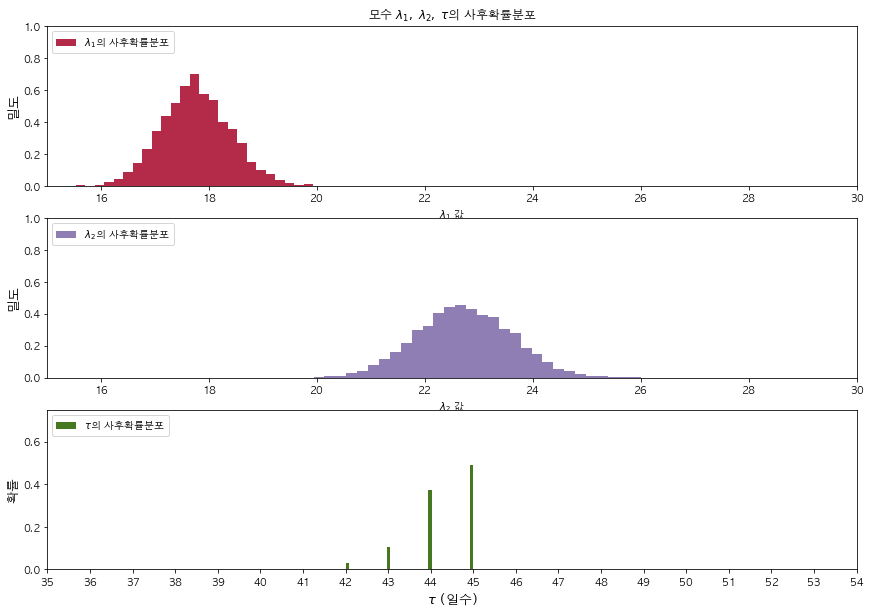

In [23]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

figsize(14.5, 10)
# 표본의 히스토그램:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="$\lambda_1$의 사후확률분포", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"모수 $\lambda_1,\;\lambda_2,\;\tau$의 사후확률분포")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ 값")
plt.ylabel(u"밀도", fontsize=13)
ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="$\lambda_2$의 사후확률분포", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ 값")
plt.ylabel(u"밀도",fontsize=13)

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"$\tau$의 사후확률분포",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (일수)",fontsize=13)
plt.ylabel(u"확률",fontsize=13);

### 1.4.3 해석

베이지안 방법론은 분포를 반환
    -> $\lambda$와 $\tau$를 분포로써 표현
    -> 